In [1]:
"""
    Script to stream news articles and compare sentiment against cryptocurrency price
    Author: Ross MacWilliam
    Date: 01/02/2021
"""

import re
import csv
from time import sleep
import requests
import json
import pandas as pd
import numpy as np
import requests
import bs4
from bs4 import BeautifulSoup
from datetime import datetime, timedelta, date

import pandas_datareader as pdr
import matplotlib.pyplot as plt

import shrimpy
import plotly.graph_objects as go
from newsapi import NewsApiClient
from yahoofinancials import YahooFinancials
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [5]:
overall_headlines = pd.read_csv('.\datasets\overall_sentiment.csv')

In [10]:
def calculate_extreme_scores(high_headlines, trading_symbol):
    high_headlines['times'] = pd.to_datetime(high_headlines['publishedAt'])
    high_headlines['hour'] = high_headlines['times'].dt.date.astype(str) + ' ' +high_headlines['times'].dt.hour.astype(str)+ ':00'
    grouped_dates = high_headlines.groupby([high_headlines['hour']])
    keys_dates = list(grouped_dates.groups.keys())

    max_cs = []
    min_cs = []

    for key in grouped_dates.groups.keys():
        data = grouped_dates.get_group(key)
        if data["compound"].max() > .2:
            max_cs.append(data["compound"].max())
        elif data["compound"].max() < -.2:
            max_cs.append(0)

        if data["compound"].min() < 0:
            min_cs.append(data["compound"].min())
        elif data["compound"].min() > 0:
            min_cs.append(0)

    extreme_scores_dict = {'Date':keys_dates,'max_scores':max_cs,'min_scores':min_cs}
    extreme_scores_df = pd.DataFrame(extreme_scores_dict)

    final_scores = []
    for i in range(len(extreme_scores_df)):
        final_scores.append(extreme_scores_df['max_scores'].values[i] + extreme_scores_df['min_scores'].values[i])

    extreme_scores_df['final_scores'] = final_scores

        
    #sentiment_Buy, sentiment_Sell = self.make_trade_call(extreme_scores_df)
        
    #self.vizualise_calls(trading_symbol, sentiment_Buy, sentiment_Sell)
        
    return extreme_scores_df

In [11]:
interval_scores = calculate_extreme_scores(overall_headlines, 'BTC')

In [12]:
interval_scores

,Date,max_scores,min_scores,final_scores
0,2021-01-25 10:00,0.9766,0.0000,0.9766
1,2021-01-25 12:00,0.9818,0.0000,0.9818
2,2021-01-25 13:00,0.7717,0.0000,0.7717
3,2021-01-25 14:00,0.0000,-0.8126,-0.8126
4,2021-01-25 15:00,0.9682,0.0000,0.9682
...,...,...,...,...
134,2021-02-02 3:00,0.0000,-0.6705,-0.6705
135,2021-02-02 5:00,0.0000,-0.9997,-0.9997
136,2021-02-02 6:00,0.0000,-0.6705,-0.6705
137,2021-02-02 7:00,0.9477,0.0000,0.9477


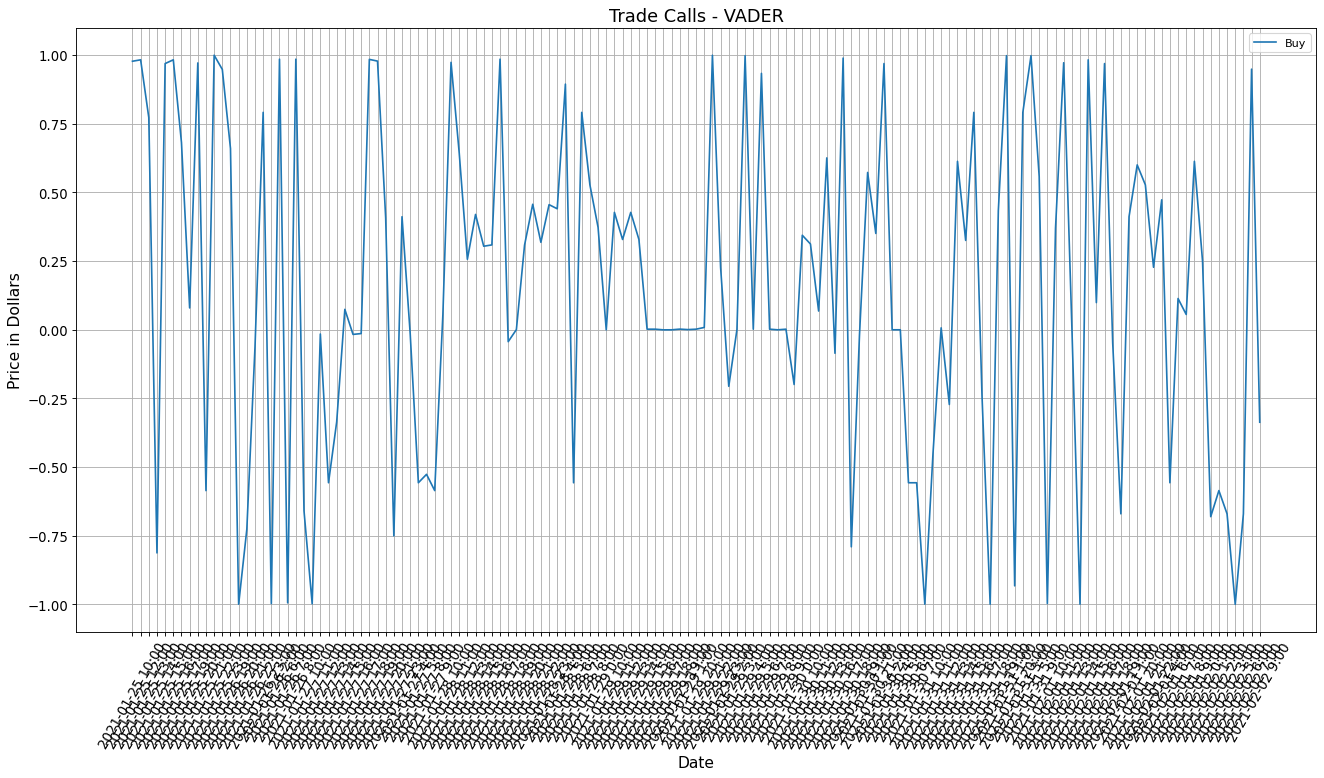

In [14]:
plt.figure(figsize=(20, 10),dpi=80)
plt.plot(interval_scores['Date'], interval_scores['final_scores'])
plt.xlabel('Date',fontsize=14)
plt.ylabel('Price in Dollars', fontsize = 14)
plt.xticks(rotation='60',fontsize=12)
plt.yticks(fontsize=12)
plt.title('Trade Calls - VADER', fontsize = 16)
plt.legend(['Buy','Sell','Close'])
plt.grid()
plt.show() 

In [15]:
df = interval_scores

In [16]:
for i in range(0,df.shape[0]-2):
    df.loc[df.index[i+2],'SMA_3'] = np.round(((df.iloc[i,1]+ df.iloc[i+1,1] +df.iloc[i+2,1])/3),1)

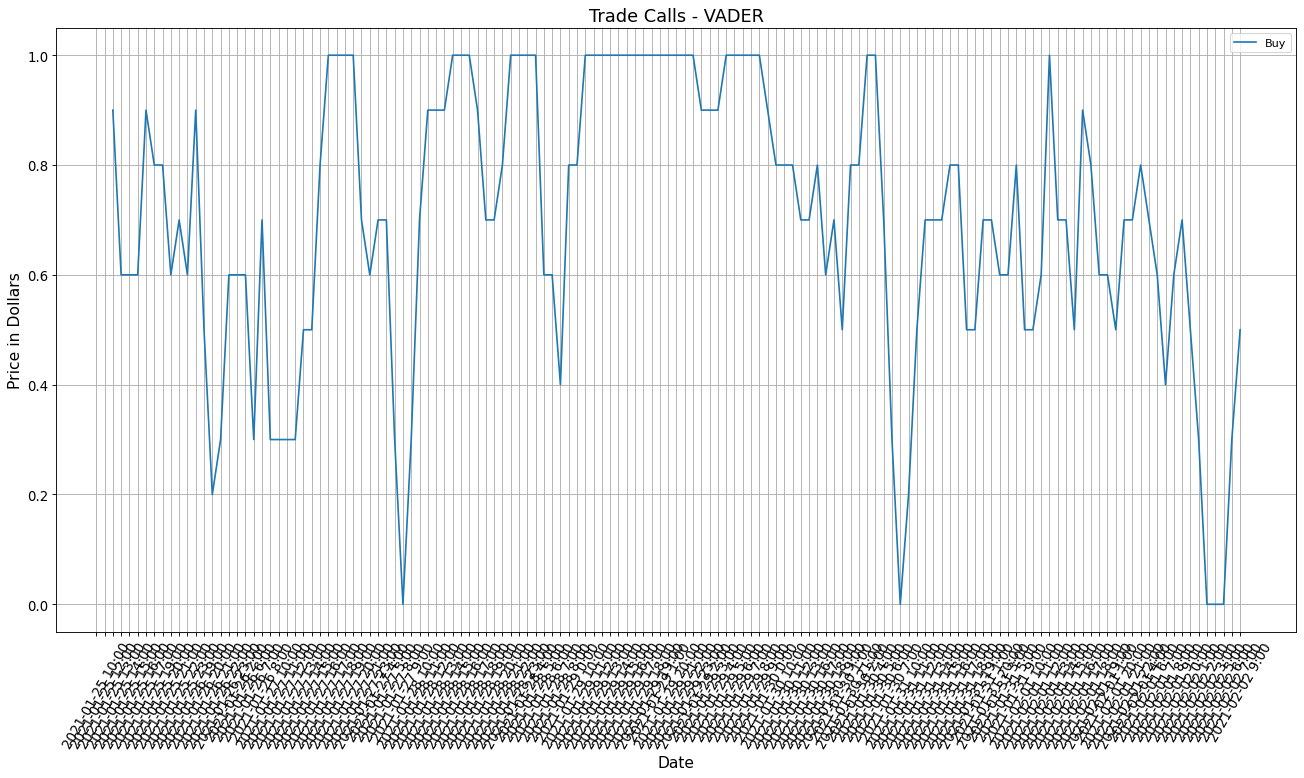

In [19]:
plt.figure(figsize=(20, 10),dpi=80)
plt.plot(df['Date'],df['SMA_3'])
plt.xlabel('Date',fontsize=14)
plt.ylabel('Price in Dollars', fontsize = 14)
plt.xticks(rotation='60',fontsize=12)
plt.yticks(fontsize=12)
plt.title('Trade Calls - VADER', fontsize = 16)
plt.legend(['Buy','Sell','Close'])
plt.grid()
plt.show() 

In [18]:
df

,Date,max_scores,min_scores,final_scores,SMA_3
0,2021-01-25 10:00,0.9766,0.0000,0.9766,NaN
1,2021-01-25 12:00,0.9818,0.0000,0.9818,NaN
2,2021-01-25 13:00,0.7717,0.0000,0.7717,0.9
3,2021-01-25 14:00,0.0000,-0.8126,-0.8126,0.6
4,2021-01-25 15:00,0.9682,0.0000,0.9682,0.6
...,...,...,...,...,...
134,2021-02-02 3:00,0.0000,-0.6705,-0.6705,0.0
135,2021-02-02 5:00,0.0000,-0.9997,-0.9997,0.0
136,2021-02-02 6:00,0.0000,-0.6705,-0.6705,0.0
137,2021-02-02 7:00,0.9477,0.0000,0.9477,0.3


In [26]:
df['pandas_SMA_3'] = df.iloc[:,1].rolling(window=20).mean()

In [27]:
df

,Date,max_scores,min_scores,final_scores,SMA_3,pandas_SMA_3
0,2021-01-25 10:00,0.9766,0.0000,0.9766,NaN,NaN
1,2021-01-25 12:00,0.9818,0.0000,0.9818,NaN,NaN
2,2021-01-25 13:00,0.7717,0.0000,0.7717,0.9,NaN
3,2021-01-25 14:00,0.0000,-0.8126,-0.8126,0.6,NaN
4,2021-01-25 15:00,0.9682,0.0000,0.9682,0.6,NaN
...,...,...,...,...,...,...
134,2021-02-02 3:00,0.0000,-0.6705,-0.6705,0.0,0.571340
135,2021-02-02 5:00,0.0000,-0.9997,-0.9997,0.0,0.521365
136,2021-02-02 6:00,0.0000,-0.6705,-0.6705,0.0,0.521365
137,2021-02-02 7:00,0.9477,0.0000,0.9477,0.3,0.519660


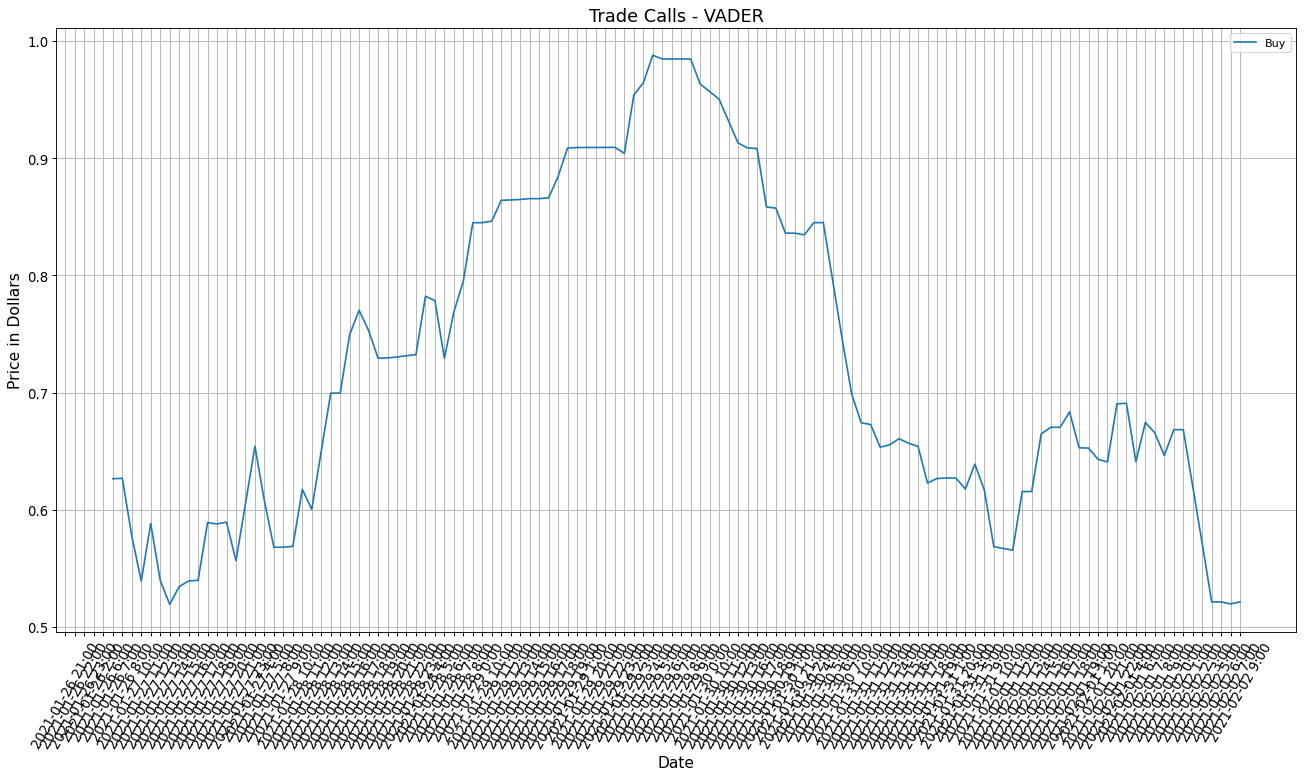

In [28]:
plt.figure(figsize=(20, 10),dpi=80)
plt.plot(df['Date'],df['pandas_SMA_3'])
plt.xlabel('Date',fontsize=14)
plt.ylabel('Price in Dollars', fontsize = 14)
plt.xticks(rotation='60',fontsize=12)
plt.yticks(fontsize=12)
plt.title('Trade Calls - VADER', fontsize = 16)
plt.legend(['Buy','Sell','Close'])
plt.grid()
plt.show() 